In [23]:
%matplotlib inline
import os
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [61]:
def create_graph():
    # Creates a tensor graph in the specified directory
    model_dir = 'imagenet'
    with gfile.FastGFile(os.path.join(model_dir,
                    'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def extraction(list_images):
    """
    Take a list of image file paths, and return features.
    """
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

    for ind, image in enumerate(list_images):
        if (ind%100 == 0):
            print('Processing %s...' % (image))
        if not gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)

    image_data = gfile.FastGFile(image, 'rb').read()

    predictions = sess.run(next_to_last_tensor,
                        {'DecodeJpeg/contents:0': image_data})

    features[ind,:] = np.squeeze(predictions)
    
    labels.append(re.split('_\d+',image.split('/')[1])[0])

    return features, labels


In [47]:
image_list = images_list('Capstone_photo/Random/')

In [49]:
random_images = extraction(image_list)

Processing Capstone_photo/Random/IMG_9071.JPG...


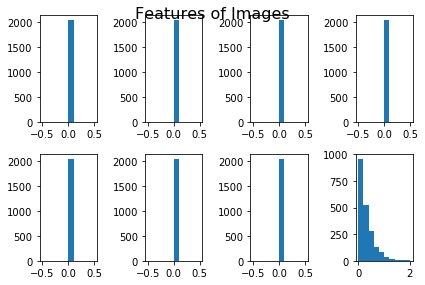

In [55]:
x = np.arange(1,2048)
fig, axes = plt.subplots(2,4)

for ax, i in zip(axes.flatten(),range(len(random_images))):
    ax.hist(random_images[i])

plt.suptitle('Features of Images',fontsize=16)
plt.tight_layout()

In [70]:
train_photos = images_list('train_photos/')

In [64]:
feature, label = extraction(kickflip)

Processing Capstone_photo/Kickflip/IMG_1816.jpg...
Processing Capstone_photo/Kickflip/IMG_1918.jpg...
Processing Capstone_photo/Kickflip/IMG_2117.jpg...
Processing Capstone_photo/Kickflip/IMG_9145.jpg...
Processing Capstone_photo/Kickflip/IMG_9247.jpg...
Processing Capstone_photo/Kickflip/IMG_9444.jpg...


In [71]:
train_photos

[]

In [93]:
sub_dirs = [x[0] for x in gfile.Walk('train_photos/')]

In [94]:
sub_dirs

['train_photos/', 'train_photos/Kickflip', 'train_photos/Ollie']

In [113]:
def image_list(image_dir):
    """Builds a list of training images from the file system.
      Analyzes the sub folders in the image directory, and returns a data structure
      describing the lists of images for each label and their paths.
      Args:
        image_dir: String path to a folder containing subfolders of images.

      Returns:
        A dictionary containing an entry for each label subfolder
      """
    # Checks if the directory name even exists!
    if not gfile.Exists(image_dir):
        print("Image directory '" + image_dir + "' not found.")
        return None
    
    result = {}
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)] # This will create a list of sub directories i.e Kickflip, ollie
    
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False # Because the first element is the root directory, we skip it to go into the sub directories
            continue
        extensions = ['jpg', 'JPG'] # Image extension
        file_list = [] # File path list of all the images in the directory
        dir_name = os.path.basename(sub_dir) # This will make the dir_name to be 'Kickflip' or 'Ollie'
        if dir_name == image_dir:
            continue
        print("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension) # Making a file path for all photos with given extension
            file_list.extend(gfile.Glob(file_glob)) # This will add the 'file_glob' string to file_list
        if not file_list:
            print('No files have been found')
            continue
        if len(file_list) < 20: # This will check the length of the file_list
            print('There is less than 20 photos in this directory! There may not be enough pictures!')
        
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower()) #This makes the label name for each spacific Image
        result[label_name] = {'dir':dir_name,
                             'train':file_list}
    return result
    

In [114]:
image_list('train_photos')

Looking for images in 'Kickflip'
Looking for images in 'Ollie'


{'kickflip': {'dir': 'Kickflip',
  'train': ['train_photos/Kickflip/IMG_1816.jpg',
   'train_photos/Kickflip/IMG_1817.jpg',
   'train_photos/Kickflip/IMG_1818.jpg',
   'train_photos/Kickflip/IMG_1819.jpg',
   'train_photos/Kickflip/IMG_1820.jpg',
   'train_photos/Kickflip/IMG_1821.jpg',
   'train_photos/Kickflip/IMG_1822.jpg',
   'train_photos/Kickflip/IMG_1823.jpg',
   'train_photos/Kickflip/IMG_1824.jpg',
   'train_photos/Kickflip/IMG_1825.jpg',
   'train_photos/Kickflip/IMG_1826.jpg',
   'train_photos/Kickflip/IMG_1827.jpg',
   'train_photos/Kickflip/IMG_1828.jpg',
   'train_photos/Kickflip/IMG_1829.jpg',
   'train_photos/Kickflip/IMG_1830.jpg',
   'train_photos/Kickflip/IMG_1831.jpg',
   'train_photos/Kickflip/IMG_1832.jpg',
   'train_photos/Kickflip/IMG_1833.jpg',
   'train_photos/Kickflip/IMG_1834.jpg',
   'train_photos/Kickflip/IMG_1835.jpg',
   'train_photos/Kickflip/IMG_1836.jpg',
   'train_photos/Kickflip/IMG_1837.jpg',
   'train_photos/Kickflip/IMG_1838.jpg',
   'train_photo

In [97]:
for sub_dir in sub_dirs:
    dir_name = os.path.basename(sub_dir)
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    print (label_name)


kickflip
ollie
